In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings(action = 'ignore')
pd.set_option('display.max_columns', 500)
%matplotlib inline

# 1. Data Load

In [2]:
target_original = pd.read_csv('data/target_v1.csv')
weather_original = pd.read_csv('data/weather_v1.csv')
hourly_smp_original = pd.read_csv('data/hourly_smp_v1.csv')

target = target_original.copy()
weather = weather_original.copy()
hourly_smp = hourly_smp_original.copy()

In [3]:
oil_price_cl_original = pd.read_csv('result/oil_price_cl.csv')
oil_price_du_original = pd.read_csv('result/oil_price_du.csv')
oil_price_brt_original = pd.read_csv('result/oil_price_brt.csv')

oil_price_cl = oil_price_cl_original.copy()
oil_price_du = oil_price_du_original.copy()
oil_price_brt = oil_price_brt_original.copy()

**daily smp data 수집 기간**  
**2018년 2월 1일 ~ 2020년 1월 31일**

**데이터 분석 결과 온도를 제외하고는 날씨 데이터에서는 유의미한 변수가 없는것으로 판단**  
**weather data 에서는 temp column만을 추출**

**oil data 수집기간**  
**2006년 4월 18일 ~ 2020년 5월 11일(주말 제외)**

# 2. EDA

### 각 table의 날짜 데이터를 date format으로 변환

In [9]:
target['date'] = pd.to_datetime(target['date'])

# oil price dataframe에서 날짜를 date column으로 변환
# '날짜'와 '코드' column은 필요 없으므로 drop
for table in ([oil_price_du, oil_price_cl, oil_price_brt]) : 
    table['date'] = pd.to_datetime(table['날짜'])
    table.drop(['날짜', '코드'], axis = 1, inplace = True)
    table.sort_values(by = ['date'], inplace = True)

# weather에 대해서도 날짜를 date column으로 변환하고, temperature을 제외한 모든 column drop
weather = weather.iloc[ : , 1:4]
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather.columns = ['date', 'temp', 'temp_QCFlag']

# hourly smp 에 대해서도 동일한 과정 진행
#hourly_smp['date'] = pd.to_datetime(hourly_smp['datetime'])
#hourly_smp.drop(['datetime'], axis = 1, inplace = True)

oil_price_cl.head(5)

,종가,date
3328,64.28,2007-04-05
3327,61.89,2007-04-10
3326,62.01,2007-04-11
3325,63.85,2007-04-12
3324,63.63,2007-04-13


**2018년 2월 1일 이전의 데이터는 모두 drop**

In [10]:
# target data의 날짜에 맞춰 2018년 2월 1일 이후의 데이터만을 sampling
oil_price_du = oil_price_du[oil_price_du['date'] >= '2018-02-01']
oil_price_cl = oil_price_cl[oil_price_cl['date'] >= '2018-02-01']
oil_price_brt = oil_price_brt[oil_price_brt['date'] >= '2018-02-01']

oil_price_du.columns = ['du_price', 'date']
oil_price_cl.columns = ['cl_price', 'date']
oil_price_brt.columns = ['brt_price', 'date']

No handles with labels found to put in legend.


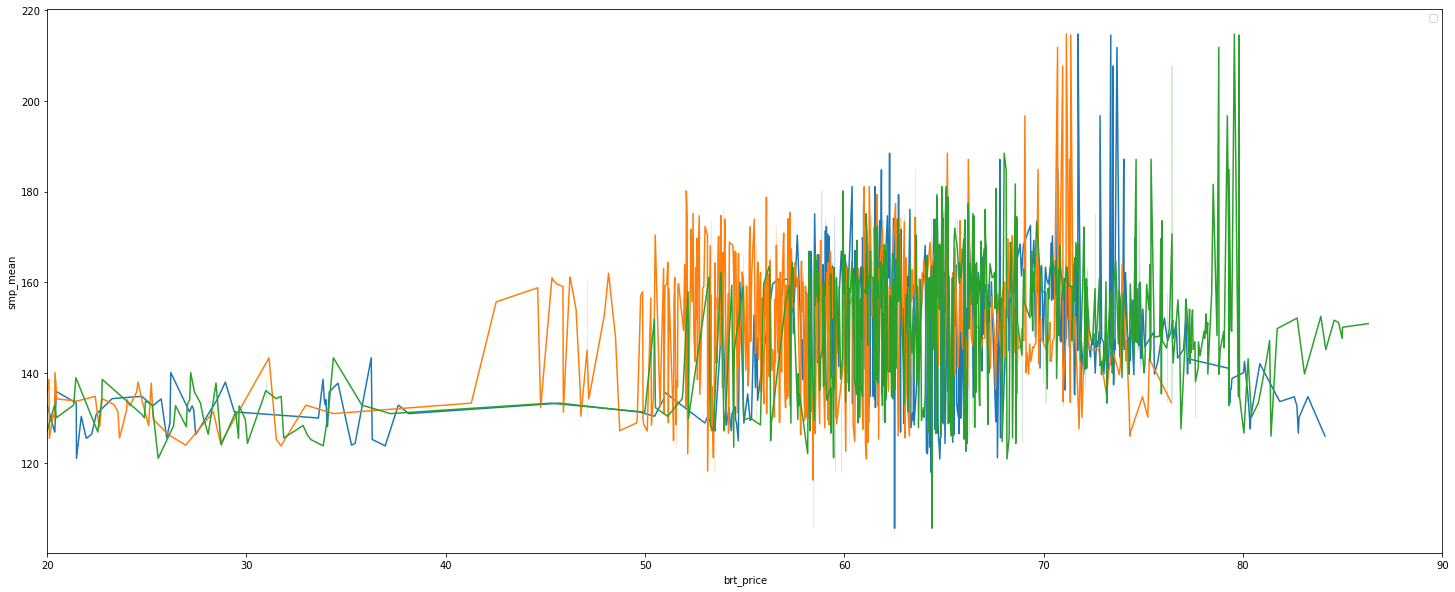

In [11]:
fig, ax = plt.subplots(figsize = (25,10))

sns.lineplot(x = oil_price_du['du_price'], y = target['smp_mean'], ax = ax)
sns.lineplot(x = oil_price_cl['cl_price'], y = target['smp_mean'], ax = ax)
sns.lineplot(x = oil_price_brt['brt_price'], y = target['smp_mean'], ax = ax)
plt.xlim(20, 90)
ax.legend()
plt.show()

### smp, supply, oil_pirce, weather를 합친 train 제작

In [12]:
train = target.copy()

for table in ([oil_price_du, oil_price_cl, oil_price_brt, weather]) :
    train = pd.merge(train, table, on = 'date')

train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.month
train['week'] = train['date'].dt.week

train.head(5)

,date,smp_max,smp_min,smp_mean,supply,du_price,cl_price,brt_price,temp,temp_QCFlag,month,day,week
0,2018-02-02,163.86,116.84,134.19,86.64,65.74,65.45,68.58,3.3,0.0,2,2,5
1,2018-02-02,163.86,116.84,134.19,86.64,65.74,65.45,68.58,3.1,0.0,2,2,5
2,2018-02-02,163.86,116.84,134.19,86.64,65.74,65.45,68.58,1.5,0.0,2,2,5
3,2018-02-02,163.86,116.84,134.19,86.64,65.74,65.45,68.58,4.1,0.0,2,2,5
4,2018-02-02,163.86,116.84,134.19,86.64,65.74,65.45,68.58,2.2,NaN,2,2,5


## train data의 feature간 상관관계 분석

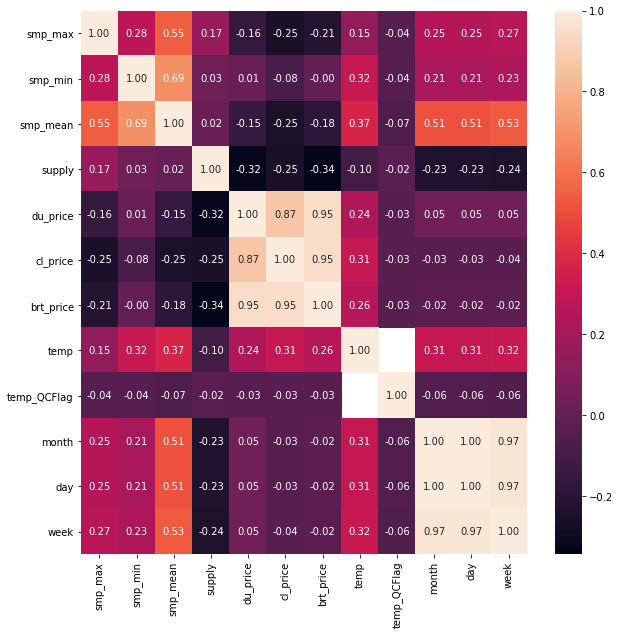

In [13]:
fig, ax = plt.subplots(figsize = (10, 10))

sns.heatmap(train.corr(), annot = True, fmt = '.2f')